<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2021/blob/main/sessions/data-curation/Data_Processing_%26_Curation_for_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2021 Deep Learning Lab:**
# **Data Processing & Curation for Deep Learning**

### In this session, we will build a **toolbox** of data processing techniques useful for deep learning applications.

### Code
The code in this demo has been primarily written by the developers listed below

### Data
A single anonymized sample case is provided 

### Developer
- Kirti Magudia, MD, PhD, Duke University Medical Center, Durham, NC

### Learning Objectives
1. Extract relevant data from radiology and pathology reports
2. Understand how to generate and process image-based annotations
3. Perform image registration and normalization
4. Recognize features of data formats ideal for deep learning

### Course Description
This course will provide attendees with the essential tools to perform data processing and curation necessary for deep learning projects. Attendees will start with free text radiology and pathology reports as well as anonymized DICOM data and process data into a unified data file ready for deep learning applications.

### Acknowledgments
The pathology report analysis was previously presented at the 2020 Radiological Society of North America Annual Meeting.

We would also like to acknowledge the general advice of research collaborators:
- Christopher Bridge, PhD
- Abhejit Rajagopal, PhD

# System Setup & Downloading the Data

**_OPTIONAL_:** Save a copy of this notebook in your Google Drive folder by selecting _Save a Copy in Drive_ from the _File_ menu in the top left corner of this page.

**_NEXT_:** Make sure you are using the **Chrome browser**.

In [ ]:
#@title **Setting up the runtime environment...**
#@markdown Running this cell will install the necessary libraries.

%%capture

!pip install pydicom 
!pip install dicom2nifti
!pip install nipype

import matplotlib.pyplot as plt
import os
import numpy as np
import pydicom
import shutil as shutil
import dicom2nifti
import nibabel as nib
import h5py
import re
from skimage import exposure
from zipfile import ZipFile
from pathlib import Path
from google.colab import files
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Install ANTs toolbox
!gdown --id 1N1Qx-R5tLCX5EhXPoPdyg6YvEkDtf-cD
!7z x ANTs-28-03-2019.7z
!cp bin/* /usr/local/bin

In [ ]:
#@title **Downloading the data**
#@markdown Running this cell will download the data for this demo.

!wget -q https://github.com/RSNA/AI-Deep-Learning-Lab-2021/raw/main/sessions/data-curation/Sample_DICOM.zip

file_name='/content/Sample_DICOM.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('input data file unzipped')


input data file unzipped


In [ ]:
#@title **Visualizing the data**
#@markdown Running this cell will show you the directory structure for the provided sample prostate MRI data. We have three folders, each of which contains a series of files for T2 weighted imaging (T2WI), diffusion weighted imaging (DWI) and an ADC map (ADC). (Note: that the lesion.nii.gz is a backup file provided for the demo)
#@markdown 
#@markdown This data has been directly exported from PACS in the DICOM format. This data can be loaded into a DICOM viewer to be visualized. A free option available to Mac OS users is Osirix Lite.

for current_dir, subdirs, files1 in os.walk('/content/Sample_DICOM' ):
    # Current Iteration Directory
    print(current_dir )

    # Directories
    for dirname in subdirs:
        print( '\t' + dirname )

    # Files
    for filename in files1:
        print( '\t' + filename )


# # Set path variable to the directory where the data is located
# path = Path('/content/Sample_DICOM')

# # Command line "magic" command to show directory contents
# !ls {path}/**/*


/content/Sample_DICOM
	T2
	DWI
	ADC
	lesion.nii.gz
/content/Sample_DICOM/T2
	1.3.6.1.4.1.20319.85384303979335059511612812493096073633.dcm
	1.3.6.1.4.1.20319.277619070754900862510913324424196183240.dcm
	1.3.6.1.4.1.20319.83913507345269304027658473307566384057.dcm
	1.3.6.1.4.1.20319.302852807793880783830662655040155219869.dcm
	1.3.6.1.4.1.20319.182695923090729314598601052712672308602.dcm
	1.3.6.1.4.1.20319.246783595409207656993849023413807161470.dcm
	1.3.6.1.4.1.20319.53508314335241744133964290231238309911.dcm
	1.3.6.1.4.1.20319.309485030965426665180555928561628660716.dcm
	1.3.6.1.4.1.20319.94454139029220730573420448385478204374.dcm
	1.3.6.1.4.1.20319.325468869781218879309429429697155492053.dcm
	1.3.6.1.4.1.20319.149295715715521692498631976808013277792.dcm
	1.3.6.1.4.1.20319.246231523294433057461201374849039999441.dcm
	1.3.6.1.4.1.20319.251449391416298231807849238571691564439.dcm
	1.3.6.1.4.1.20319.241194454539069275494007235189703095490.dcm
	1.3.6.1.4.1.20319.159165458525153839306831514

## **Preparing this data for annotation and further processing**

DICOM files are not a convenient format to work with for deep learning. The first step that we will take will be conversion of our DICOM files to [nifti](https://nifti.nimh.nih.gov/), an open source image file format that has good interoperability between many available image processing tools and packages. 

In [ ]:
#@title **Conversion of our data to nifti file format**
#@markdown Run this cell to convert our DICOM files to nifti files. Each folder of DICOM files (a series) will be converted into a nifti file

path='/content/Sample_DICOM'
niftipath = os.path.join(path, 'nifti')
os.makedirs(niftipath, exist_ok=True)
for series in ['T2','DWI','ADC']:
  dicom2nifti.dicom_series_to_nifti(os.path.join(path,series),os.path.join(niftipath, (series+'.nii')), reorient_nifti=True)
print('data converted')

data converted


In [ ]:
#@title **Download nifti file for T2 series**
#@markdown Run this cell to download our nifti file for the T2 series. This file will be used for annotation.

#@markdown A chrome browser is a requirement for this step. An alternative is to navigate to the Sample_DICOM folder, then the nifti folder and download the T2.nii file.

files.download('/content/Sample_DICOM/nifti/T2.nii')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Image Annotation**

There are many options for image annotation. One of the easiest and most versatile is an open source tool called **itk-SNAP**. Please click [here](http://www.itksnap.org/pmwiki/pmwiki.php?n=Downloads.SNAP3) to download and install this tool for the next step. There are versions for windows, macOS and linux available.

![picture](https://drive.google.com/uc?export=view&id=1AI79GbVqApIr3MBDD4xcYPu_VDBNPb78)

Next, open **itk-SNAP** and open your nifti file for the T2 series. Click on this **A** to see maximize our visualization of the axial images.

![picture](https://drive.google.com/uc?export=view&id=1KcPjMRVojKz_IiggA6kfufrltAnApmAD)

Click on the **layers** button

![picture](https://drive.google.com/uc?export=view&id=1HFnLdj9uVa9kMZuFcFYyHIgKVt9XC50y)

Navigate to the **contrast** tab and click **auto** to optimize the window and level settings for our images.

![picture](https://drive.google.com/uc?export=view&id=18okMKwYM4BGQESU-Wou5QDOoBFRCxLig)

Now we are ready to annotate our lesion! Click on the **paintbrush** tool and annotate all slices containing our lesion in the right peripheral zone of the prostate gland. This involves a **left click and drag** of your mouse. Right click and drag erases the annotation. To navigate between the slices you can use your scroll wheel

![picture](https://drive.google.com/uc?export=view&id=1eNRHw05mhK9OfBu3qJUydkfOfjj4F6YI)

When you are done annotating, click **Segmentation** in the system toolbar and select **save segmentation**. Please save this file with the name "**lesion**".

![picture](https://drive.google.com/uc?export=view&id=1KB3Kg40VLYSOw82lLMjG9OQgxTtcom7-)

In [ ]:
#@title **Uploading your annotation file**
#@markdown Click here to be prompted to upload your **lesion** file. 

#@markdown If you choose to not upload a file, there is a backup lesion file in your Sample_DICOM folder that will be automatically used as needed.

files.upload()

Saving lesion.nii.gz to lesion.nii.gz


{'lesion.nii.gz': b"\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xec\xd31N\x1bA\x18\x86\xe1\x9dp\x80p\x85\xd4T\x88\x1e\xa3p\rHA\x85\x84DAA\x87\xc4%\xa8\xe8)R\xd1R!\xf9\x08\x94\xe4\x18\xf4\x80\xb1@r\xd6\xe3e\x05r3\xdf\xf3\xfc\xb2\xb7\xb1\xc7\xb2\xde\x7f\x0eJ7\xc2Y\xb7\xd1u\xa5+\xbf\xde\xde\xe6\xd3\xf3cs\xfe\xb8\xbc?|\xde\x99\xfc\x99\xbd\x9e_&{\xcb\xe7\xdc\xee\xcf>3\xf9\xf8\xce\x98_^\xa7\xf7\x7fqyt~19y\xf8\xb9{\xf3\xef\xfa\xf7\xdf\xa7\xe3\xe9\xd5\xe3\xdd\xf4\xbbg\x9fnm\x7f\xf7\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

## **Image Registration**

You may have multiple series (by CT or MRI) that you want registered to each other for your deep learning project. There are many ways to do this, some easier than others. I have found the open source library [**Advanced Normalization Tools**](http://stnava.github.io/ANTs/) easy to use and very helpful for this purpose. 

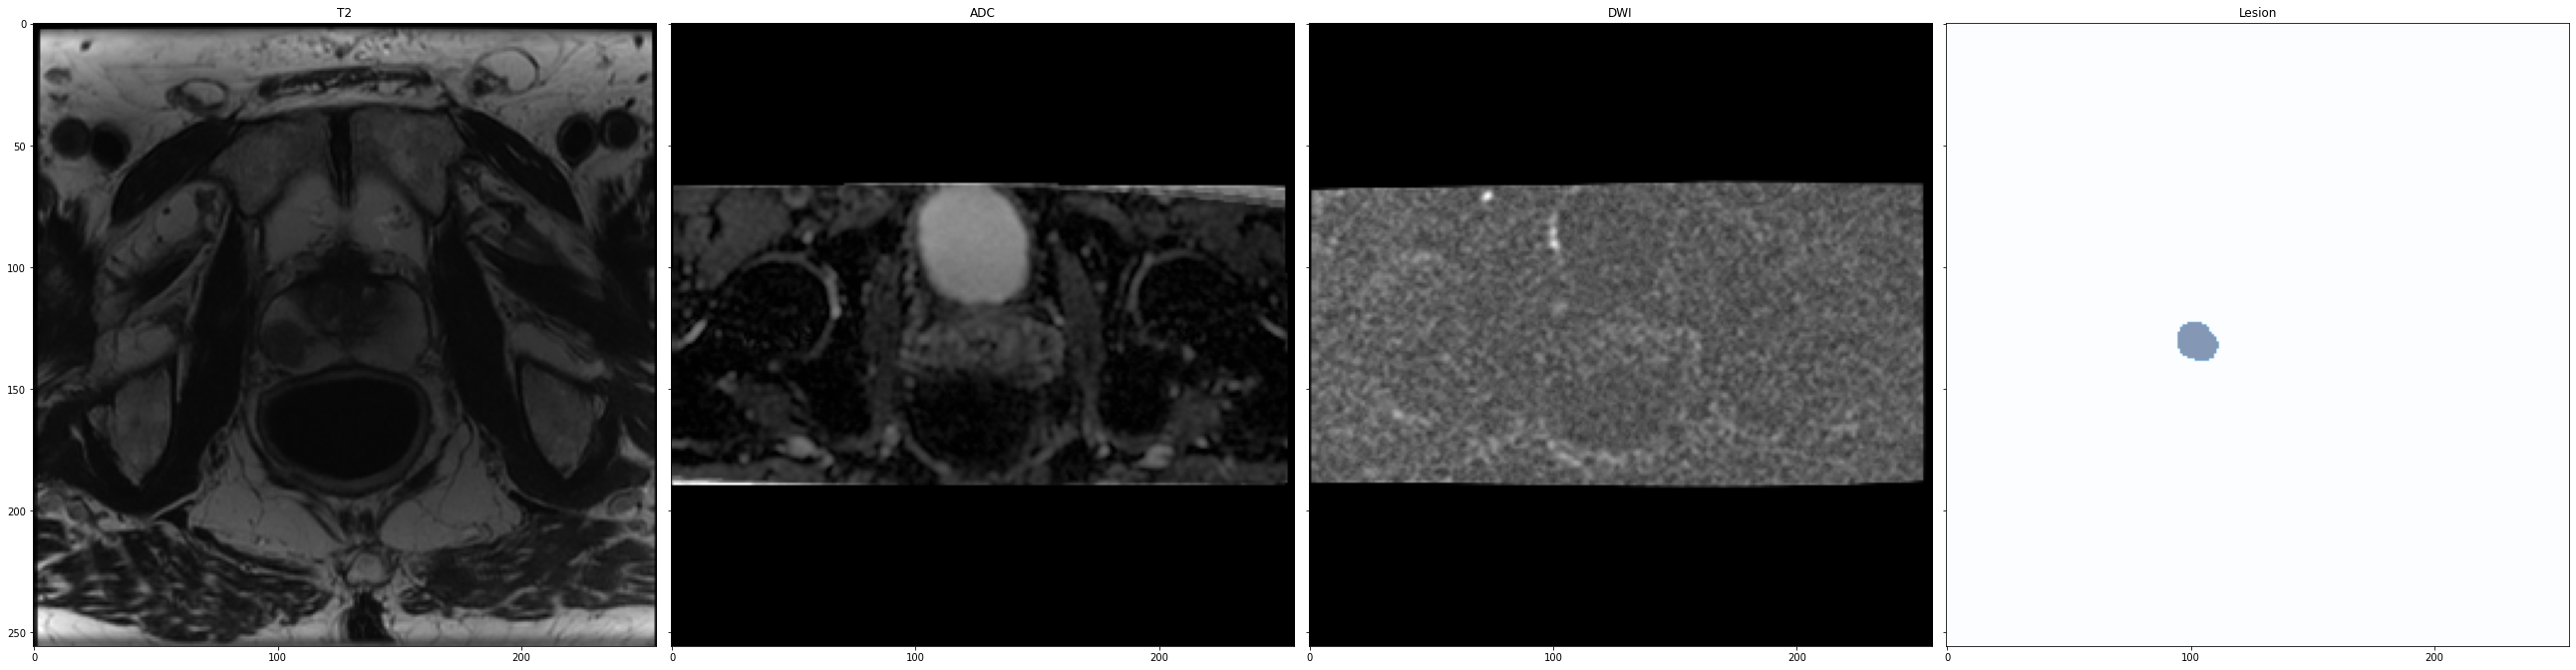

In [ ]:
#@title **Visualize your images before registration**
#@markdown Click here to visualize your images before registration.

#@markdown Note that ADC and DWI images are not registered to T2 images. Note that the lesion file is registered to T2 as that is those are the images we used for the annotation.

#If no lesion file, copy it from uploaded data folder
if os.path.exists('/content/lesion.nii.gz')==False:
  shutil.copyfile('/content/Sample_DICOM/lesion.nii.gz','/content/lesion.nii.gz')

#get pixel data from nifti files
T2image = nib.load('/content/Sample_DICOM/nifti/T2.nii')
data_T2 = np.rot90(T2image.get_fdata())
ADCimage = nib.load('/content/Sample_DICOM/nifti/ADC.nii')
data_ADC = np.rot90(ADCimage.get_fdata())
DWIimage = nib.load('/content/Sample_DICOM/nifti/DWI.nii')
data_DWI = np.rot90(DWIimage.get_fdata())
lesionimage = nib.load('/content/lesion.nii.gz')
data_lesion =np.rot90(lesionimage.get_fdata())

#plot image 
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(36, 24), sharex=True, sharey=True)
ax0 = axes[0];
ax1 = axes[1];
ax2 = axes[2];
ax3 = axes[3];
ax0.imshow(data_T2[:,:, 12], cmap='gray');
ax0.set_title('T2');
ax1.imshow(data_ADC[:,:, 12], cmap='gray');
ax1.set_title('ADC');
ax2.imshow(data_DWI[:, :, 12], cmap='gray');
ax2.set_title('DWI');
ax3.imshow(data_lesion[:, :, 12], cmap='Blues',alpha=0.5);
ax3.set_title('Lesion');
plt.tight_layout()
plt.rcParams.update({'font.size': 40})

In [ ]:
#@title **Register your images**
#@markdown Click here to register your T2, DWI and ADC series. Different pixel and slice spacing as well as field of view is used for T2 versus DWI and ADC imaging.

path='/content/Sample_DICOM'
niftipath = os.path.join(path, 'nifti')

!antsApplyTransforms --default-value 0 --float 0 --input /content/Sample_DICOM/nifti/DWI.nii --interpolation Linear --output /content/Sample_DICOM/nifti/DWI_regis.nii --reference-image /content/Sample_DICOM/nifti/T2.nii --transform identity
!antsApplyTransforms --default-value 0 --float 0 --input /content/Sample_DICOM/nifti/ADC.nii --interpolation Linear --output /content/Sample_DICOM/nifti/ADC_regis.nii --reference-image /content/Sample_DICOM/nifti/T2.nii --transform identity
print('completed')

completed


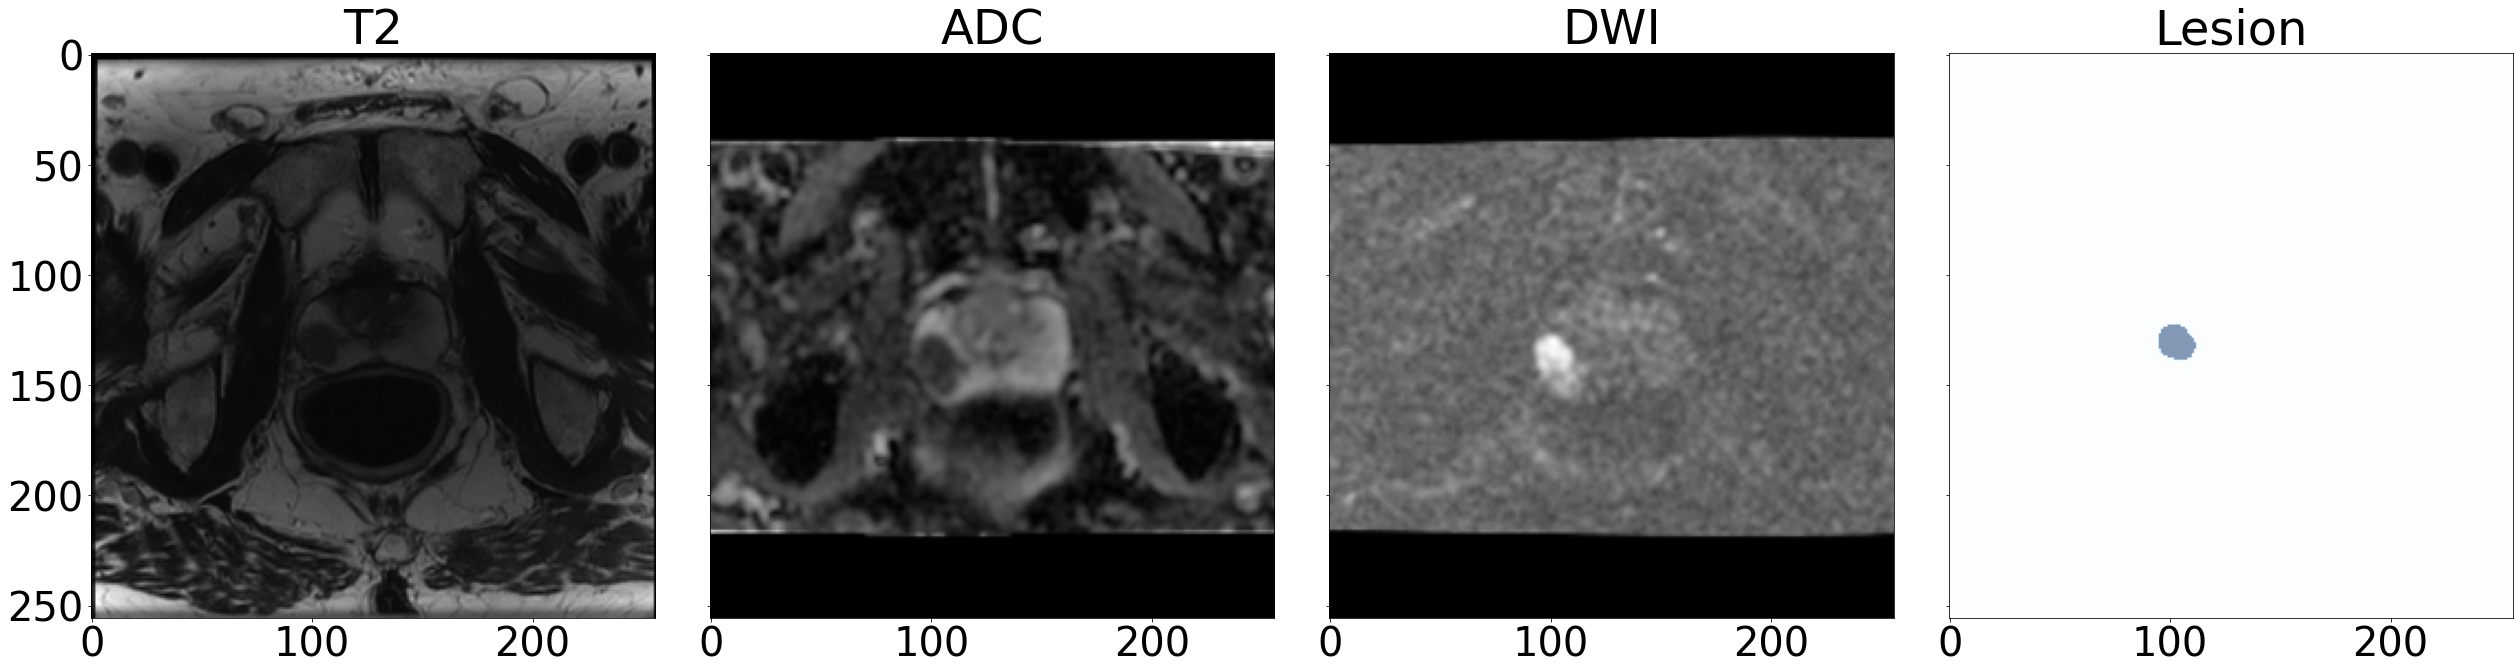

In [ ]:
#@title **Visualize your images**
#@markdown Click here to visualize your registered images.

#get pixel data from nifti files
T2image = nib.load('/content/Sample_DICOM/nifti/T2.nii')
data_T2 = np.rot90(T2image.get_fdata())
ADCimage = nib.load('/content/Sample_DICOM/nifti/ADC_regis.nii')
data_ADC = np.rot90(ADCimage.get_fdata())
DWIimage = nib.load('/content/Sample_DICOM/nifti/DWI_regis.nii')
data_DWI = np.rot90(DWIimage.get_fdata())
lesionimage = nib.load('/content/lesion.nii.gz')
data_lesion =np.rot90(lesionimage.get_fdata())

#plot image 
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(36, 24), sharex=True, sharey=True)
ax0 = axes[0];
ax1 = axes[1];
ax2 = axes[2];
ax3 = axes[3];
ax0.imshow(data_T2[:,:, 12], cmap='gray');
ax0.set_title('T2');
ax1.imshow(data_ADC[:,:, 12], cmap='gray');
ax1.set_title('ADC');
ax2.imshow(data_DWI[:, :, 12], cmap='gray');
ax2.set_title('DWI');
ax3.imshow(data_lesion[:, :, 12], cmap='Blues',alpha=0.5);
ax3.set_title('Lesion');
plt.tight_layout()
plt.rcParams.update({'font.size': 40})

## **Image Normalization**

Image normalization can be a critical step to help correct for scanner and exam variation in aquisition, especially for MRI images.

In [ ]:
#@title **Normalize your images**
#@markdown Click here to normalize your images. This normalization is being performed over the entire imaged volume for each series. An alternate approach would be to normalize based on pixels within a region of interest.

#Define function for normalization
def normalize_equalize(T2):
    p1, p2 = np.percentile(T2[T2!=0], (0.1, 99.9))
    T2_rescale = exposure.rescale_intensity(T2, in_range=(p1, p2),out_range=(0,1))
    T2_rescale_equalize=exposure.equalize_hist(T2_rescale)
    return T2_rescale_equalize

#Normalize each series
data_T2_norm=normalize_equalize(data_T2)
data_ADC_norm=normalize_equalize(data_ADC)
data_DWI_norm=normalize_equalize(data_DWI)


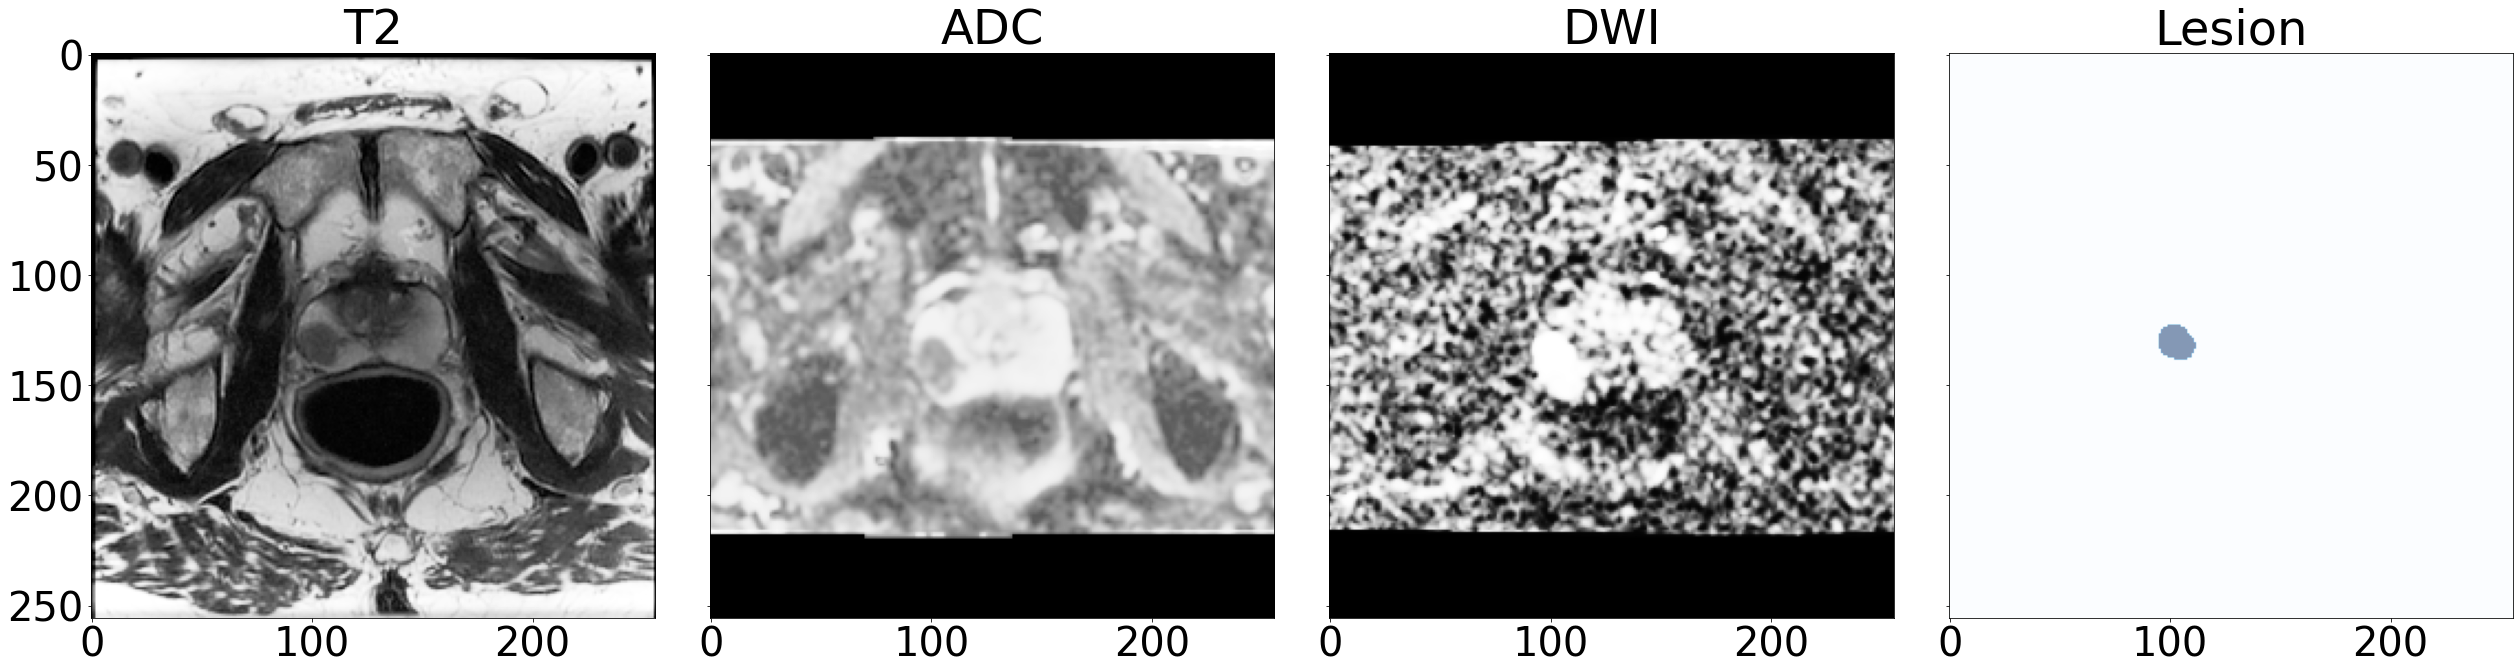

In [ ]:
#@title **Visualize your normalized images**
#@markdown Click here to visualize your normalized images.


#plot image 
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(36, 24), sharex=True, sharey=True)
ax0 = axes[0];
ax1 = axes[1];
ax2 = axes[2];
ax3 = axes[3];
ax0.imshow(data_T2_norm[:,:, 12], cmap='gray');
ax0.set_title('T2');
ax1.imshow(data_ADC_norm[:,:, 12], cmap='gray');
ax1.set_title('ADC');
ax2.imshow(data_DWI_norm[:, :, 12], cmap='gray');
ax2.set_title('DWI');
ax3.imshow(data_lesion[:, :, 12], cmap='Blues',alpha=0.5);
ax3.set_title('Lesion');
plt.tight_layout()
plt.rcParams.update({'font.size': 40})

## **Free text report processing**

Oftentimes, valuable information for ground truth will need to be processed from free text reports. For this demonstration, the prostate lesion that we annotated needs to be linked to results from a biopsy report.

In [ ]:
#@title **View the free text pathology report**
#@markdown Click here to view the raw free text pathology report.

report='XXX DEPARTMENT OF PATHOLOGY XXX ADDRESS TEL: XXX  FAX: XXXX  ; ;SURGICAL PATHOLOGY REPORT  ;Patient Name: XXX Med. Rec.#: XXXXXXX DOB: XX/XX/XXXX (Age: XX) Sex: Male Accession #: XX Visit #: XXX Service Date: XX/XX/XXXX Received: XX/XX/XXXX Location: XX Client:XX  Physician(s): XX; ;FINAL PATHOLOGIC DIAGNOSIS  ;A. Prostate, right apex, needle core biopsy:  High-grade prostatic intraepithelial neoplasia (HGPIN); see comment.   ;B. Prostate, right mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;C. Prostate, right base, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;D. Prostate, right anterior, needle core biopsy:  Atypical small acinar proliferation (ASAP); see comment.   ;E. Prostate, left apex, needle core biopsy:  Benign prostatic tissue.  ;F. Prostate, left mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 3+3=6; see comment.    ;G. Prostate, left base, needle core biopsy:  Benign prostatic tissue.   ;H. Prostate, left anterior, needle core biopsy:  Benign prostatic tissue.    ;I. Prostate, "left mid US lesion", needle core biopsy:  Benign prostatic tissue.    ;J. Prostate, "right base US lesion", needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;K. Prostate, "MRI #1 right mid/base posterior", needle core biopsy: Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.     ; ;COMMENT: Immunohistochemical staining for p63/CK903/P504S was performed on blocks A1, D1, and F1. In part A (right apex), all glands show at least partially retained basal cells with some of the glands demonstrating increased P504S staining, supporting high-grade prostatic intraepithelial neoplasia (HGPIN). In part D (right anterior), a focus composed of 7-8 small atypical glands are seen, and these glands demonstrate no retained basal cells by immunostaining, but lack definite infiltrative growth pattern with no increased P504S staining, and are best classified as atypical small acinar proliferation (ASAP). In part F (left mid), atypical glands show no retained basal cells with increased P504S staining, supporting the diagnosis of adenocarcinoma.   ;The Gleason pattern 4 in this case is of the expansile cribriform and cribriform types.   ;Specimen B  2 of 2 cores contain carcinoma. The total length of tumor in all of the cores is 11 mm. The total length of tissue in all of the cores is 21 mm. The percentage of the tissue involved by tumor is 52%. The percentage of tumor greater than Gleason pattern 3 is 100%. Perineural invasion is not present. No extraprostatic tumor is seen.  ;Specimen C  2 of 2 cores contain carcinoma. The total length of tumor in all of the cores is 21 mm. The total length of tissue in all of the cores is 28 mm. The percentage of the tissue involved by tumor is 75%. The percentage of tumor greater than Gleason pattern 3 is &gt; 95%. Perineural invasion is not present. No extraprostatic tumor is seen.  ;Specimen F  1 of 3 cores contains carcinoma. The total length of tumor in all of the cores is 2 mm. The total length of tissue in all of the cores is 34 mm. The percentage of the tissue involved by tumor is 6%. The percentage of tumor greater than Gleason pattern 3 is 0%. Perineural invasion is not present. No extraprostatic tumor is seen.  ;Specimen J  2 of 2 cores contain carcinoma. The total length of tumor in all of the cores is 28 mm. The total length of tissue in all of the cores is 31 mm. The percentage of the tissue involved by tumor is 90%. The percentage of tumor greater than Gleason pattern 3 is &gt;95%. Perineural invasion is not present. No extraprostatic tumor is seen.  ;Specimen K  2 of 3 cores contain carcinoma. The total length of tumor in all of the cores is 16 mm. The total length of tissue in all of the cores is 37 mm. The percentage of the tissue involved by tumor is 43%. The percentage of tumor greater than Gleason pattern 3 is &gt;95%. Perineural invasion is not present. No extraprostatic tumor is seen.  ; ;Specimen(s) Received A:Right apex B:Right mid C:Right base D:Right anterior E:Left apex F:Left mid G:Left base H:Left anterior I:Left mid US lesion J:Right base US lesion K:MRI #1 right mid/base posterior  ; ;Clinical History The patient is a 72-year-old man with an elevated PSA in two subsequent occasions (28 and 31), estimated prostatic volume of 29.4 cc with ultrasound revealing a right anterior base and left mid gland lesions, and MRI revealing a right mid/base lesion with extracapsular extension. No previous biopsies. Overall PI-RADS v2 score = 5.   ; ;Gross Description The case is received in 11 parts, each labeled with the patient name and medical record number.  ;Part A is received in formalin and additionally labeled "right apex," consists of two 0.1 cm-thick cores of soft tan-white tissue.  The cores each have a length of 2 cm and 1.5 cm.  The specimen is entirely submitted in cassette A1.  (lds)  ;Part B is received in formalin and additionally labeled "right mid," consists of two 0.1 cm-thick cores of soft yellow-gold tissue.  The cores each have a length of 1 cm and 1.1 cm.  The specimen is entirely submitted in cassette B1.  (lds)  ;Part C is received in formalin and additionally labeled "right base," consists of two 0.1 cm-thick cores of soft yellow-gold tissue.  The cores each have a length of 1.7 cm and 1.1 cm.  The specimen is entirely submitted in cassette C1.  (lds)  ;Part D is received in formalin and additionally labeled "right anterior," consists of a single 0.1 cm-thick core of soft tan-white tissue.  The core has a length of 1.6 cm.  The specimen is entirely submitted in cassette D1.  (lds)  ;Part E is received in formalin and additionally labeled "left apex," consists of two 0.1 cm-thick cores of soft tan-white tissue.  The cores each have a length of 1.5 cm and 1 cm.  The specimen is entirely submitted in cassette E1.  (lds)  ;Part F is received in formalin and additionally labeled "left mid," consists of two 0.1 cm-thick cores of soft tan-white tissue.  The cores each have a length of 2 cm and 1.7 cm.  The specimen is entirely submitted in cassette F1.  (lds)  ;Part G is received in formalin and additionally labeled "left base," consists of two 0.1 cm-thick cores of soft tan-white tissue.  The cores each have a length of 1.5 cm and 1.8 cm.  The specimen is entirely submitted in cassette G1.  (lds)  ;Part H is received in formalin and additionally labeled "left anterior," consists of a single 0.1 cm-thick core of soft tan-white tissue.  The core has a length of 2.2 cm.  The specimen is entirely submitted in cassette H1.  (lds)  ;Part I is received in formalin and additionally labeled "US lesion left mid," consists of two 0.1 cm-thick cores of soft tan-white tissue.  The cores each have a length of 1.8 cm and 1.4 cm.  The specimen is entirely submitted in cassette I1.  (lds)  ;Part J is received in formalin and additionally labeled "US lesion right base," consists of two 0.1 cm-thick cores of soft white-pink tissue.  The cores each have a length of 1.6 cm and 1.5 cm.  The specimen is entirely submitted in cassette J1.  (lds)  ;Part K is received in formalin and additionally labeled "MRI #1, right mid/base posterior," consists of three 0.1 cm-thick cores of soft white-pink tissue.  The cores each have a length of 0.4 cm, 1.3 cm and 2 cm.  The specimen is entirely submitted in cassette K1.  (lds)  ;All controls performed with the immunohistochemical stains reported above reacted appropriately. These immunohistochemical stains were developed and their performance characteristics determined by the XXX Department of Pathology. They have not been cleared or approved by the U. S. Food and Drug Administration. The FDA has determined that such clearance or approval is not necessary. These tests are used for clinical purposes. They should not be regarded as investigational or for research. This laboratory is certified under the Clinical Laboratory Improvement Amendments of 1988 ("CLIA") as qualified to perform high-complexity clinical testing.  ;Diagnosis based on gross and microscopic examinations.  Final diagnosis made by attending pathologist following review of all pathology slides.  The attending pathologist has reviewed all dictations, including prosector work, and preliminary interpretations performed by any resident involved in the case and performed all necessary edits before signing the final report.  ;XXX/Pathology Resident XXX/Pathologist      Electronically signed out on XX/XX/XXXX XX:XX  ;'
print(report)

XXX DEPARTMENT OF PATHOLOGY XXX ADDRESS TEL: XXX  FAX: XXXX  ; ;SURGICAL PATHOLOGY REPORT  ;Patient Name: XXX Med. Rec.#: XXXXXXX DOB: XX/XX/XXXX (Age: XX) Sex: Male Accession #: XX Visit #: XXX Service Date: XX/XX/XXXX Received: XX/XX/XXXX Location: XX Client:XX  Physician(s): XX; ;FINAL PATHOLOGIC DIAGNOSIS  ;A. Prostate, right apex, needle core biopsy:  High-grade prostatic intraepithelial neoplasia (HGPIN); see comment.   ;B. Prostate, right mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;C. Prostate, right base, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;D. Prostate, right anterior, needle core biopsy:  Atypical small acinar proliferation (ASAP); see comment.   ;E. Prostate, left apex, needle core biopsy:  Benign prostatic tissue.  ;F. Prostate, left mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 3+3=6; see comment.    ;G. Prostate, left base, needle core biopsy:  Benign prostati

In [ ]:
#@title **Trim the free text pathology report**
#@markdown Click here to trim the pathology report to the section with results of interest

report_trim = report.split('FINAL PATHOLOGIC DIAGNOSIS')[1].split('COMMENT:')[0]
print(report_trim)

  ;A. Prostate, right apex, needle core biopsy:  High-grade prostatic intraepithelial neoplasia (HGPIN); see comment.   ;B. Prostate, right mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;C. Prostate, right base, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;D. Prostate, right anterior, needle core biopsy:  Atypical small acinar proliferation (ASAP); see comment.   ;E. Prostate, left apex, needle core biopsy:  Benign prostatic tissue.  ;F. Prostate, left mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 3+3=6; see comment.    ;G. Prostate, left base, needle core biopsy:  Benign prostatic tissue.   ;H. Prostate, left anterior, needle core biopsy:  Benign prostatic tissue.    ;I. Prostate, "left mid US lesion", needle core biopsy:  Benign prostatic tissue.    ;J. Prostate, "right base US lesion", needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;K. Prostate,

In [ ]:
#@title **Split the free text pathology report into each individual result**
#@markdown Click here to split the free text report into each individual result

import re 

def path_process(report):
    #split by path result by location
    report1 = re.split('[A-Z][.] ', report)
    if len(report1)==1:
        report1 = re.split('[0-9][.] ', report.split('CLINICAL DATA')[0].split('++++++++++Addendum.++++++++++')[0].split(
                                   'COMMENT')[0])
    # remove leading prostate phrase
    report2 = [x.lstrip(' ').lstrip('Prostate').lstrip(' gland').lstrip(', ').lstrip(' - ')
               for x in report1]
    return report2

report2=path_process(report_trim)

for i in report2:
  print(i)

;
right apex, needle core biopsy:  High-grade prostatic intraepithelial neoplasia (HGPIN); see comment.   ;
right mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;
right base, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;
right anterior, needle core biopsy:  Atypical small acinar proliferation (ASAP); see comment.   ;
left apex, needle core biopsy:  Benign prostatic tissue.  ;
left mid, needle core biopsy:  Prostatic adenocarcinoma, Gleason score 3+3=6; see comment.    ;
left base, needle core biopsy:  Benign prostatic tissue.   ;
left anterior, needle core biopsy:  Benign prostatic tissue.    ;
"left mid US lesion", needle core biopsy:  Benign prostatic tissue.    ;
"right base US lesion", needle core biopsy:  Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.    ;
"MRI #1 right mid/base posterior", needle core biopsy: Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.     ; ;


In [ ]:
#@title **Identify MRI target results**
#@markdown Click here to identify any pathology results for MRI targets

reportMR=[x for x in report2 if any(y in x for y in ['MR','MRI'])]

print(reportMR)

['"MRI #1 right mid/base posterior", needle core biopsy: Prostatic adenocarcinoma, Gleason score 4+4=8; see comment.     ; ;']


In [ ]:
#@title **Identify MRI target result**
#@markdown Click here to isolate the Gleason score for the MRI target. The Gleason Grade is more convenient to store for ground truth as a single integer and therefore has also been calculated.

gleason=reportMR[0].split('+')
print('Gleason Score =',int(gleason[0].strip(' ')[-1]),'+',int(gleason[1].strip(' ')[0]))

#convert to more useable ISUP score
def GleasonGrade(gleason1, gleason2):
    if (gleason1 + gleason2) == 0:
        GG = 0
    elif ((gleason1 + gleason2) <= 6) & ((gleason1 + gleason2) != 0):
        GG = 1
    elif (gleason1 == 3) and (gleason2 == 4):
        GG = 2
    elif (gleason1 == 4) and (gleason2 == 3):
        GG = 3
    elif (gleason1 + gleason2) == 8:
        GG = 4
    elif (gleason1 + gleason2) == 9 or (gleason1 + gleason2) == 10:
        GG = 5
    else: GG=float('nan')
    return GG

GG=GleasonGrade(int(gleason[0].strip(' ')[-1]),int(gleason[1].strip(' ')[0]))
print('Gleason Grade =', GG)

Gleason Score = 4 + 4
Gleason Grade = 4


## **Conversion to ideal format for storage and model development**

You have now imported in your MRI images, annotated a lesion, registered series, normalized series and processed the pathology result for the annotated lesion. 

You have multiple options for how to store this data. A convenient option is to choose a file format with the ability to handle heterogeneous data simultaneously including numerical arrays and strings. One such option is [**hdf5**](https://www.hdfgroup.org/solutions/hdf5/).

In [ ]:
#@title **Convert your data to hdf5**
#@markdown Click here to add your imaging data, lesion annotation and pathology groundtruth to a single hdf5 file.

#@markdown Here you have the choice for whether to combine your imaging inputs and/or lesion annotation into a multichannel input versus keeping each separate from each other and likely combining in a later step. For now, we have kept them separate

#@markdown Feel free to download this file to explore offline

#create hdf5 file
f=h5py.File('/content/final_product.hdf5','w')

#assign datasets (datasets have to be numerical data)
dset = f.create_dataset('T2', data=data_T2_norm)
dset = f.create_dataset('ADC', data=data_ADC_norm)
dset = f.create_dataset('DWI', data=data_DWI_norm)
dset = f.create_dataset('Lesion_mask', data=data_lesion)
dset = f.create_dataset('Lesion_GG', data=GG)

#assign attributes (can be strings or lists of data)
f.attrs['ID']='final_product'

print('hdf5 file created')
print('datasets:')
print(list(f.keys()))
print('attributes:')
print(list(f.attrs.keys()))

hdf5 file created
datasets:
['ADC', 'DWI', 'Lesion_GG', 'Lesion_mask', 'T2']
attributes:
['ID']
